Final notebooks to include every graph/table

## Data

[Download](https://x.com/i/communitynotes/download-data) the data from x.com. The description of each dataset is [here](https://communitynotes.x.com/guide/en/under-the-hood/download-data).
For accessing the scores, the [note scoring algorithm](https://github.com/twitter/communitynotes) needs to applied on the provided datasets. 

In this notebook we applied scoring algorithm to the data before Feb 2025 and used it for Regression Discontinuty Desgin analysis (applied on 2024 data only). Otherwise, we used most recent note and note_history notebook containing data to end of June 2025.

[bring merge scripts and updaing dates here.]

# Environment

see requirements.txt or communitynotes2025-05-09.yml

# Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle
import calendar
from sklearn import linear_model
import statsmodels.formula.api as smf
import os

In [6]:
# Files and locations
userloc = os.getcwd()
data_raw = userloc+'/data2025raw/' # download from x.com
data_proc = userloc+'/data2025proc/' # generating by CN code, run on HPC
data_post = userloc+'/data2025post/' # post-processing, generated by our scripts

In [2]:
# import notes
notes = pd.read_parquet('notes.parquet', engine='auto')
# limit it to the last day of June 2025
notes = notes[notes.createdAt < pd.Timestamp(2025, 7, 1)]

### Active authors per month
written at least one note in the reference month

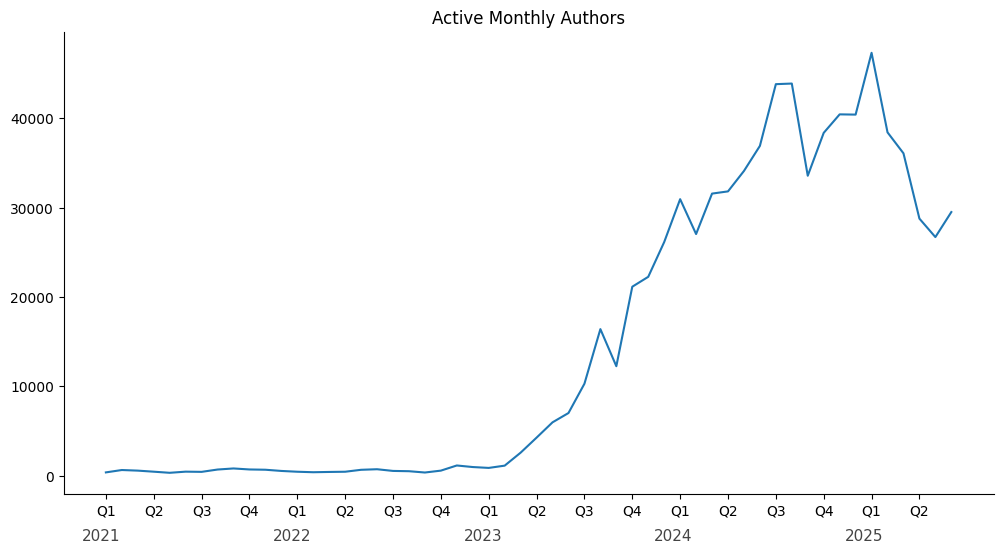

In [3]:
# active users per month
active_authors_monthly = notes.groupby(['createdAtYear', 'createdAtMonth'])\
    .agg({'noteAuthorParticipantId': 'nunique'}).reset_index()
active_authors_monthly.rename(columns={'noteAuthorParticipantId': 'count'}, inplace=True)
# plot active authors monthly
fig, ax = plt.subplots(figsize=(12,6))
# ax.plot(active_authors_monthly.index,active_authors_monthly['count'])
ax.plot(active_authors_monthly['count'])

ax.set_xticks(np.arange(0,len(active_authors_monthly), step=3))
# set quartely labels
labels = [''] * len(ax.get_xticks())
for idx, element in enumerate(labels):
    labels[idx] = 'Q' + str(idx%4 + 1)

ax.set_xticklabels(labels)
# add years
for idx, year in enumerate(range(2021,2026)):
    ax.text(idx*.205 + .02 , -.1, str(year), size=11, color='#444', transform=ax.transAxes)
ax.set_title('Active Monthly Authors')
ax.spines[['right', 'top']].set_visible(False)

### Cumulative contribution of most active authors
Looking at published (helpful) notes

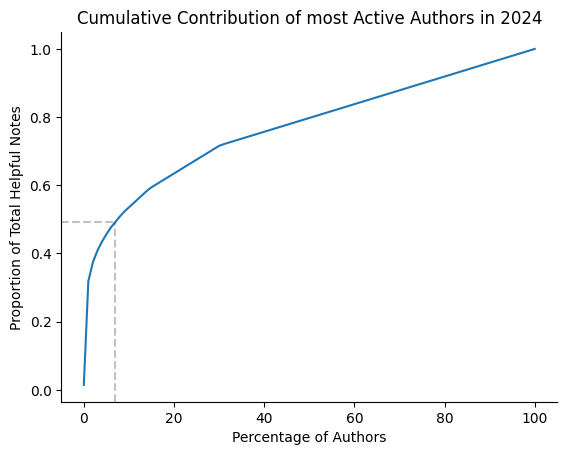

In [15]:
rated = pd.read_parquet('rated_notes_compact.parquet', engine='auto')
rated_2024 = rated[(rated.createdAt >= pd.Timestamp(2024, 1, 1)) &
                    (rated.createdAt < pd.Timestamp(2025, 1, 1))]
rated_2024_pub = rated_2024[rated_2024['finalRatingStatus'] == 'CURRENTLY_RATED_HELPFUL']
df = rated_2024_pub.groupby('noteAuthorParticipantId')['noteId']\
    .count().sort_values(ascending=False).reset_index()
df.rename(columns={'noteId': 'note_count'}, inplace=True)

# make a plot of cumulative percentages
contributions = dict()

for author_percent in range(101):
    contributions[author_percent] = df.loc[:round(len(df)*author_percent/100)]['note_count'].sum()\
          / len(rated_2024_pub)

ax = sns.lineplot(x=contributions.keys(), y=contributions.values())
ax.set_title('Cumulative Contribution of most Active Authors in 2024')
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel('Percentage of Authors')
ax.set_ylabel('Proportion of Total Helpful Notes')
# save xlims
xrange = ax.get_xlim()
yrange = ax.get_ylim()
# add 50% contribution line
c = .5
x, y = min(contributions.items(), key=lambda x: abs(c - x[1]))
# add dashed line for the x and y
ax.hlines(y=y, xmin=xrange[0], xmax=x, ls='--', color="#44444452")
ax.vlines(x=x, ymin=yrange[0], ymax=y, ls='--', color="#44444452")
ax.set_xlim(xrange)
ax.set_ylim(yrange)
plt.show()

### Heatmap for active authors
What percentage of authors remained active after their first note in the upcoming years?

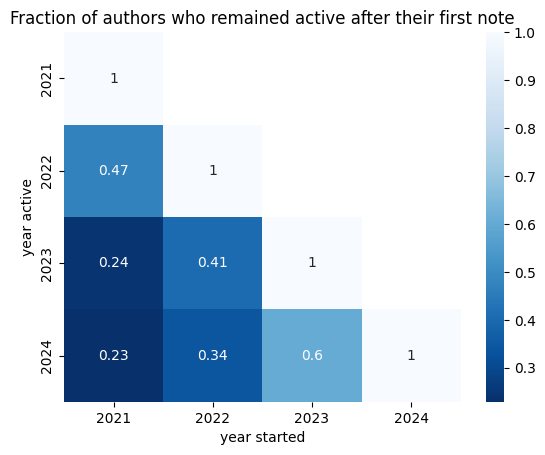

In [5]:
# make a dict of the list of unique authors each year
distinct_authors_dict = {}

for year in range(2021, 2025):
    distinct_authors_dict[year] = notes[notes['createdAtYear'] == year]['noteAuthorParticipantId'].unique()
# create a dateframe for comparing persistant authors during years
year_range = range(2021, 2025)
index = [year for year in year_range]
remain_active = pd.DataFrame(columns=index, index=index)
remain_active_matrix = np.empty(len(year_range))
for year_start in year_range:
    for year_active in year_range:
        if year_start <= year_active:
            remain_active.loc[year_active, year_start] = \
                len(np.intersect1d(distinct_authors_dict[year_start], distinct_authors_dict[year_active])) \
                    / len(distinct_authors_dict[year_start])
# plot
ax = plt.subplot()
# remove the upper triangle
mask = np.triu(np.ones_like(remain_active))
# set the diagonal to 0; so it wouldn't be masked
np.fill_diagonal(mask, 0)
sns.heatmap(remain_active.astype(float), annot = True, mask=mask, cmap='Blues_r', ax=ax)

ax.set_xlabel('year started')
ax.set_ylabel('year active')
ax.set_title('Fraction of authors who remained active after their first note')
plt.show()

### born to dead ratio

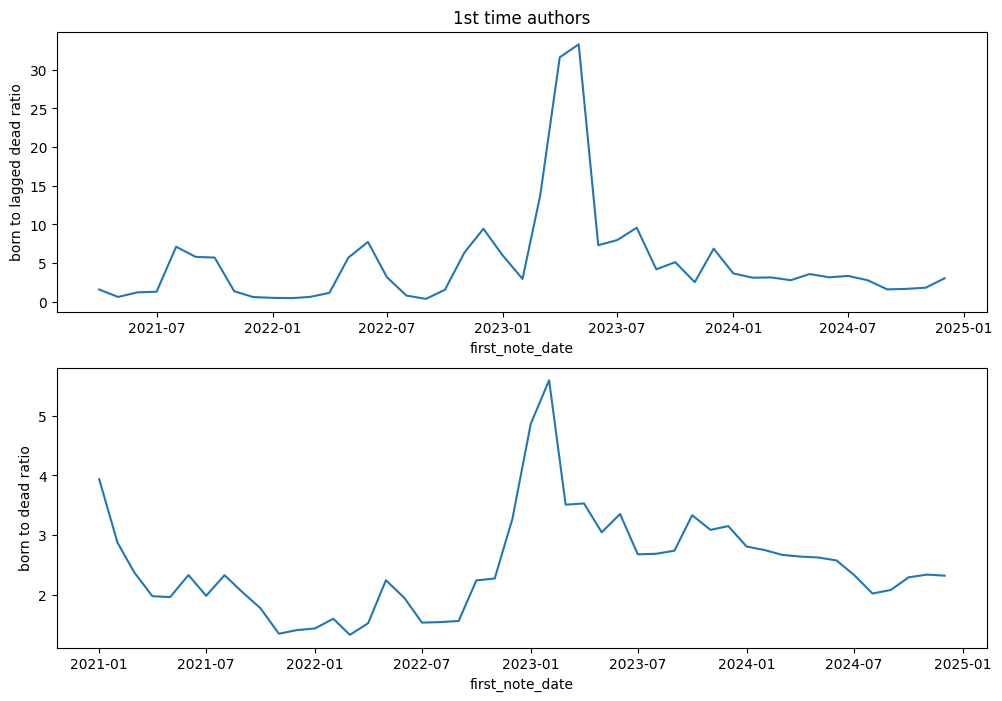

In [ ]:
#TODO decide on which graph to keep

# check if authors were inactive for 4 months after their first note
# part of code was suggested by Gemini

#number of months for inactivity
n = 4
# import notes
notes = pd.read_parquet('notes.parquet', engine='auto')
notes['createdAt'] = pd.to_datetime(notes['createdAt'])

#TODO remove authors who joined before 2024

# Find the first note date for each author
first_note = notes.groupby('noteAuthorParticipantId')['createdAt'].min().reset_index()
first_note.rename(columns={'createdAt': 'first_note_date'}, inplace=True)

# Merge the first note dates back into the original DataFrame
df = pd.merge(notes, first_note, on='noteAuthorParticipantId')

# Calculate the date 4 months after the first note
df['four_months_after_first'] = df['first_note_date'] + pd.DateOffset(months=n)

# Filter for notes within 4 months
df['note_within_4_months'] = (df['createdAt'] > df['first_note_date']) & \
    (df['createdAt'] <= df['four_months_after_first'])

# Aggregate to determine if any note was made in the 4 months
df = df.groupby('noteAuthorParticipantId')['note_within_4_months'].any().reset_index()


# merge author list with first note df
first_note = pd.merge(first_note, df, on='noteAuthorParticipantId')
# remove authors who joined after end of 2024
first_note = first_note[first_note['first_note_date'] < pd.Timestamp(2025, 1, 1)]
# now count monthly
df_monthly = first_note.set_index('first_note_date').resample('MS').count()
df_monthly['written_again'] = first_note.groupby(pd.Grouper(key='first_note_date', freq='MS'))\
    ['note_within_4_months'].sum()
df_monthly['not_written_again'] = df_monthly['note_within_4_months'] - df_monthly['written_again']
df_monthly.reset_index(inplace=True)
df_monthly.drop('noteAuthorParticipantId', axis=1, inplace=True)
df_monthly.rename(columns={'note_within_4_months': 'count_author'}, inplace=True)

# Let's check born/dead ratio
# dead: someone who hasn't written in the past n months
# born: for 1st time: write their 1st note; for 10+: write their 10th note
# in the 10+ plot, some authors can be dead multiple times, but born once
fig, ax = plt.subplots(2,1, figsize=(12,8))
n = 3
df_monthly['dead'] = df_monthly['not_written_again'].shift(n, fill_value=0)
born_to_dead = df_monthly['count_author'] / df_monthly['dead']

sns.lineplot(x=df_monthly['first_note_date'], y=born_to_dead, ax=ax[0])

ax[0].set_title('1st time authors')
ax[0].set_ylabel('born to lagged dead ratio')
sns.lineplot(x=df_monthly['first_note_date'], 
             y=df_monthly['count_author']/df_monthly['not_written_again'],
             ax=ax[1])

ax[1].set_ylabel('born to dead ratio')

plt.show()

### Number of Rating vs Helpfulness in 2024

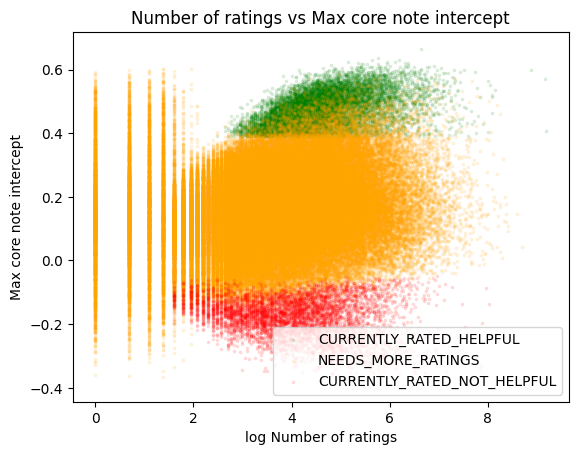

In [ ]:
rated = pd.read_parquet(data_post+'rated_notes_compact.parquet', engine='auto')
#Restricting our analysis to only 2024 notes

rated_2024 = rated[(rated.createdAt >= pd.Timestamp(2024, 1, 1)) &
                    (rated.createdAt < pd.Timestamp(2025, 1, 1))]

# Find the first note written by each author, and if that author goes on to write another note
first_notes = rated_2024.groupby('noteAuthorParticipantId')\
    [['finalRatingStatus', 'numRatings', 'decidedBy','coreNoteIntercept', 'coreNoteInterceptMax']]\
    .first().reset_index()
have_another_note = rated_2024[rated_2024.groupby('noteAuthorParticipantId').cumcount() >= 2]\
    ['noteAuthorParticipantId'].to_list()
first_notes['if_written_again'] = first_notes['noteAuthorParticipantId'].isin(have_another_note)
# notes are scored by multiuple algorithms, but nearly 80% are scored by the core model
#  for now  restrict our analysis to thismodel
first_notes = first_notes[first_notes['decidedBy'] == 'CoreModel (v1.1)']
# Most notes have a small number of rating, a small number have very many ratinhgs
# This means the distribution of ratings is very skewed.
# We take the log of the number of ratings to make the distribution more normal


first_notes['log_numRatings']=np.log(first_notes['numRatings'])
# Plotting log(numRatings) vs coreNoteInterceptMax, with colours according to Note final statuys (finalRatingStatus )  
plt.clf()
groups = ['CURRENTLY_RATED_HELPFUL','NEEDS_MORE_RATINGS','CURRENTLY_RATED_NOT_HELPFUL']
colours=['green','orange','red']

ms=3;alphaval=0.1;

for i in range(3):
    plt.scatter(first_notes[first_notes['finalRatingStatus']==groups[i]]['log_numRatings'], first_notes[first_notes['finalRatingStatus']==groups[i]]['coreNoteIntercept'], s = ms,alpha=alphaval,color=colours[i],label=groups[i])  
    
plt.xlabel('log Number of ratings')
plt.ylabel('Max core note intercept')
plt.title('Number of ratings vs Max core note intercept')
plt.legend(loc=0)
plt.savefig('scatter_numRatings_coreNoteIntercept.png',dpi=120,bbox_inches='tight')
plt.show()

#TODO make the legend markers bigger and clearer

### Percentage of Helpful notes without NNNs

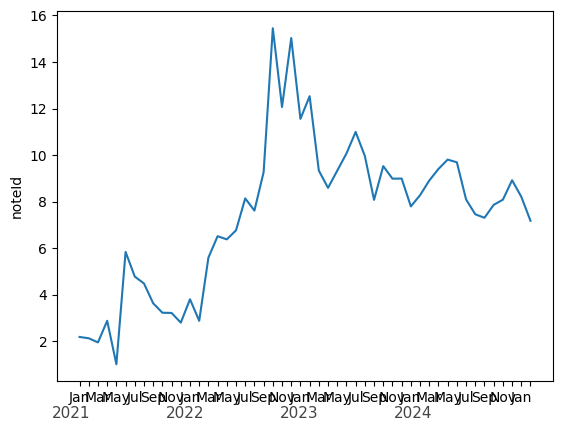

In [9]:
# TODO use updated data, update the x-axis
# a plot of monthly view of share of helpful notes
rated_pub_monthly = rated[rated['finalRatingStatus'] == 'CURRENTLY_RATED_HELPFUL']\
    .groupby(['createdAtYear', 'createdAtMonth'])['noteId'].count().reset_index()

rated_monthly = rated.groupby(['createdAtYear', 'createdAtMonth'])['noteId'].count().reset_index()
fraction_helpful_monthly = rated_pub_monthly['noteId'] / rated_monthly['noteId'] * 100
ax = sns.lineplot(x= range(len(fraction_helpful_monthly)), y=fraction_helpful_monthly)
x_labels = [calendar.month_abbr[month] for month in rated_monthly['createdAtMonth'].astype(int)]
x_locs = [i for i in range(len(x_labels))]

ax.set_xticks(x_locs)
ax.set_xticklabels(x_labels)
for label in ax.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
# add years
for idx, year in enumerate(range(2021,2025)):
    ax.text(idx*.23 -.01, -.1, str(year), size=11, color='#444', transform=ax.transAxes)

### Regression Discontinuity Design (RDD)

In [11]:
#TODO check code, remove when unnecessary

In [ ]:
# RDD 

cutoff = 0.4 #threshold at which a note is rated as helpful
bandwidth = 0.05 #window around cutoff

# We fit a model allowing for different intercepts and slopes on either side of the cutoff.

# most recent score
running_variable = first_notes['coreNoteIntercept'] # x value, continuous input

# highest score
#running_variable = first_notes['coreNoteInterceptMax'] # x value, continuous input

# Treatment = 1 if running_variable >= cutoff, else 0
treatment = np.where(running_variable >= cutoff, 1, 0)

#
outcome_variable = first_notes['if_written_again'].astype(int) # y value, binary output

# we can restrict the analysis to a window (bandwidth) around the cutoff.

mask = (running_variable > cutoff - bandwidth)  & (running_variable < cutoff + bandwidth)

data = pd.DataFrame({
    'running_variable': running_variable[mask],
    'treatment': treatment[mask],
    'outcome_variable': outcome_variable[mask],
    'control' : first_notes[mask]['log_numRatings'],
    'numRatings' : first_notes[mask]['numRatings']
})

# Center the running variable at the cutoff for easier interpretation of the intercept
data['running_variable_centered'] = data['running_variable'] - cutoff
# original
rdd_model_formula = 'outcome_variable ~ running_variable_centered * treatment'
#rdd_model_formula = 'outcome_variable ~ running_variable_centered * treatment + control'
rdd_model = smf.ols(formula=rdd_model_formula, data=data).fit()

print("\nRDD Model Summary (using all data):")
print(rdd_model.summary())


Sample Data Head:
    running_variable  treatment  outcome_variable   control  numRatings  \
13          0.415720          1                 1  1.098612           3   
45          0.384220          0                 0  5.533389         253   
48          0.365476          0                 1  3.465736          32   
74          0.371758          0                 1  1.386294           4   
98          0.424668          1                 0  5.509388         247   

    running_variable_centered  
13                   0.015720  
45                  -0.015780  
48                  -0.034524  
74                  -0.028242  
98                   0.024668  

Number of treated units: 4664
Number of control units: 5265


In [ ]:
# The coefficient for 'treatment' is the estimated effect at the cutoff.
estimated_effect = rdd_model.params['treatment']
print(f"\nEstimated Treatment Effect at the Cutoff: {estimated_effect:.4f}")

print("I think we can intepret this as a % change the chance of authoring again if published")

p_value_treatment = rdd_model.pvalues['treatment']
t_statistic_treatment = rdd_model.tvalues['treatment']
conf_int_treatment = rdd_model.conf_int().loc['treatment']

# print out p value and t-statistic for treatment
print(f"\nP-value for treatment: {p_value_treatment:.4f}")
print(f"T-statistic for treatment: {t_statistic_treatment:.4f}")
print(f"Confidence interval for treatment: " + str(conf_int_treatment))



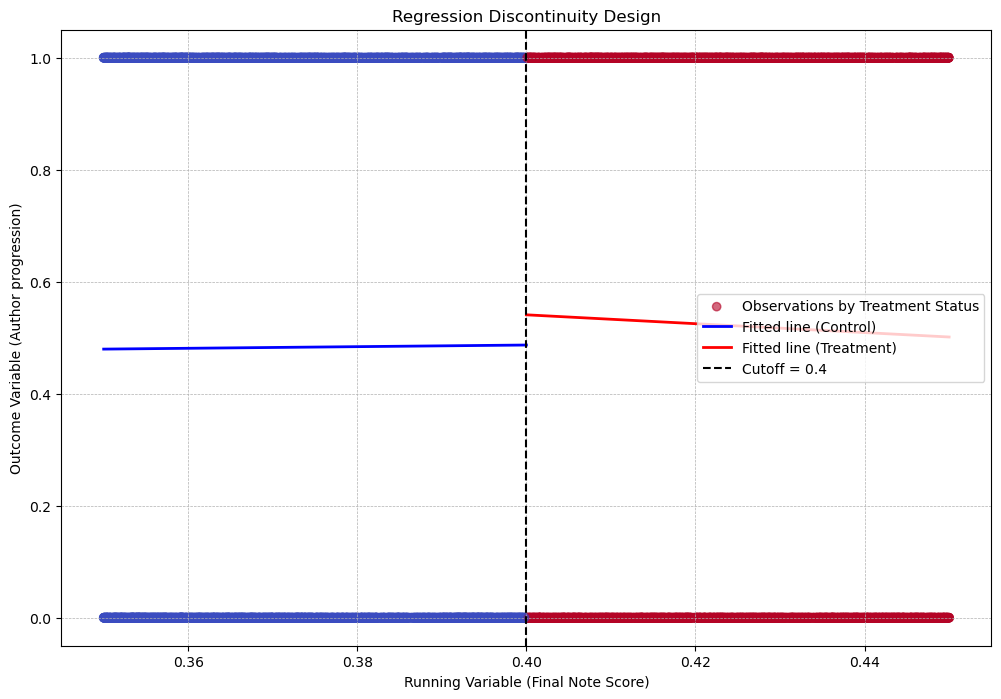

In [ ]:
# 3. Visualization
plt.figure(figsize=(12, 8))
plt.scatter(data['running_variable'], data['outcome_variable'],
            c=data['treatment'], cmap='coolwarm', alpha=0.6, label='Observations by Treatment Status')

# Plot regression lines for each side of the cutoff
# For values below the cutoff (treatment=0)
x_below = np.linspace(data['running_variable'].min(), cutoff, 100)
y_below = rdd_model.params['Intercept'] + rdd_model.params['running_variable_centered'] * (x_below - cutoff)

# For values above the cutoff (treatment=1)
x_above = np.linspace(cutoff, data['running_variable'].max(), 100)
y_above = (rdd_model.params['Intercept'] + rdd_model.params['treatment']) + \
          (rdd_model.params['running_variable_centered'] + rdd_model.params['running_variable_centered:treatment']) * (x_above - cutoff)

plt.plot(x_below, y_below, color='blue', linestyle='-', linewidth=2, label='Fitted line (Control)')
plt.plot(x_above, y_above, color='red', linestyle='-', linewidth=2, label='Fitted line (Treatment)')

plt.axvline(x=cutoff, color='black', linestyle='--', label=f'Cutoff = {cutoff}')
plt.xlabel('Running Variable (Final Note Score)')
plt.ylabel('Outcome Variable (Author progression)')
plt.title('Regression Discontinuity Design')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('plots/RDD.png',bbox_inches='tight',dpi=120)
plt.show()

